<table width="100%">
<tr style="background-color: red;"><td><font color="white">SimpleITK conventions:</font></td></tr>
<tr><td>
<ul>
<li>Points are represented by vector-like data types: Tuple, Numpy array, List.</li>
<li>Matrices are represented by vector-like data types in row major order.</li>
<li>Initializing the DisplacementFieldTransform using an image requires that the image's pixel type be sitk.sitkVectorFloat64</li>
<li>Initializing the DisplacementFieldTransform using an image will "clear out" your image (your alias to the image will point to an empty, zero sized, image).</li>
</ul>
</td></tr>
</table>

# SimpleITK Transformation Types
This notebook introduces the transformation types supported by SimpleITK and illustrates how to "promote" transformations from a lower to higher parameter space (e.g. 3D translation to 3D rigid).  

<table width="100%">
<tr><td><a href="http://www.itk.org/Doxygen/html/classitk_1_1TranslationTransform.html">TranslationTransform</a></td><td>2D or 3D, translation</td></tr>
  <tr><td><a href="http://www.itk.org/Doxygen/html/classitk_1_1VersorTransform.html">VersorTransform</a></td><td>3D, rotation represented by a versor</td></tr>
  <tr><td><a href="http://www.itk.org/Doxygen/html/classitk_1_1VersorRigid3DTransform.html">VersorRigid3DTransform</a></td><td>3D, rigid transformation with rotation represented by a versor</td></tr>
  <tr><td><a href="http://www.itk.org/Doxygen/html/classitk_1_1Euler2DTransform.html">Euler2DTransform</a></td><td>2D, rigid transformation with rotation represented by a Euler angle</td></tr>
  <tr><td><a href="http://www.itk.org/Doxygen/html/classitk_1_1Euler3DTransform.html">Euler3DTransform</a></td><td>3D, rigid transformation with rotation represented by Euler angles</td></tr>
  <tr><td><a href="http://www.itk.org/Doxygen/html/classitk_1_1Similarity2DTransform.html">Similarity2DTransform</a></td><td>2D, composition of isotropic scaling and rigid transformation with rotation represented by a Euler angle</td></tr>
  <tr><td><a href="http://www.itk.org/Doxygen/html/classitk_1_1Similarity3DTransform.html">Similarity3DTransform</a></td><td>3D, composition of isotropic scaling and rigid transformation with rotation represented by a versor</td></tr>
  <tr><td><a href="http://www.itk.org/Doxygen/html/classitk_1_1ScaleTransform.html">ScaleTransform</a></td><td>2D or 3D, anisotropic scaling</td></tr>
  <tr><td><a href="http://www.itk.org/Doxygen/html/classitk_1_1ScaleVersor3DTransform.html">ScaleVersor3DTransform</a></td><td>3D, rigid transformation and anisotropic scale is <bf>added</bf> to the rotation matrix part (not composed as one would expect)</td></tr>
  <tr><td><a href="http://www.itk.org/Doxygen/html/classitk_1_1ScaleSkewVersor3DTransform.html">ScaleSkewVersor3DTransform</a></td><td>3D, rigid transformation with anisotropic scale and skew matrices <bf>added</bf> to the rotation matrix part (not composed as one would expect)</td></tr>
  <tr><td><a href="http://www.itk.org/Doxygen/html/classitk_1_1AffineTransform.html">AffineTransform</a></td><td>2D or 3D, affine transformation.</td></tr>
  <tr><td><a href="http://www.itk.org/Doxygen/html/classitk_1_1BSplineTransform.html">BSplineTransform</a></td><td>2D or 3D, deformable transformation represented by a sparse regular grid of control points. </td></tr>
  <tr><td><a href="http://www.itk.org/Doxygen/html/classitk_1_1DisplacementFieldTransform.html">DisplacementFieldTransform</a></td><td>2D or 3D, deformable transformation represented as a dense regular grid of vectors.</td></tr>
  <tr><td><a href="http://www.itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1Transform.html">Transform</a></td>
  <td>A generic transformation. Can represent any of the SimpleITK transformations, and a <b>composite transformation</b> (stack of transformations concatenated via composition, last added, first applied). </td></tr>
  </table>

In [1]:
import SimpleITK as sitk
import numpy as np
      
from __future__ import print_function
   
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.html.widgets import interact, fixed

OUTPUT_DIR = "Output"

print(sitk.Version())

SimpleITK Version: 0.9.0
Compiled: May 14 2015 02:53:27



:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Points in SimpleITK

### Utility functions

A number of functions that deal with point data in a uniform manner.

In [2]:
import numpy as np

def point2str(point, precision=1):
    """
    Format a point for printing, based on specified precision with trailing zeros. Uniform printing for vector-like data 
    (tuple, numpy array, list).
    
    Args:
        point (vector-like): nD point with floating point coordinates.
        precision (int): Number of digits after the decimal point.
    Return:
        String represntation of the given point "xx.xxx yy.yyy zz.zzz...".
    """
    return ' '.join(format(c, '.{0}f'.format(precision)) for c in point)


def uniform_random_points(bounds, num_points):
    """
    Generate random (uniform withing bounds) nD point cloud. Dimension is based on the number of pairs in the bounds input.
    
    Args:
        bounds (list(tuple-like)): list where each tuple defines the coordinate bounds.
        num_points (int): number of points to generate.
    
    Returns:
        list containing num_points numpy arrays whose coordinates are within the given bounds.
    """
    internal_bounds = [sorted(b) for b in bounds]
         # Generate rows for each of the coordinates according to the given bounds, stack into an array, 
         # and split into a list of points.
    mat = np.vstack([np.random.uniform(b[0], b[1], num_points) for b in internal_bounds])
    return list(mat[:len(bounds)].T)


def target_registration_errors(tx, point_list, reference_point_list):
  """
  Distances between points transformed by the given transformation and their
  location in another coordinate system. When the points are only used to evaluate
  registration accuracy (not used in the registration) this is the target registration
  error (TRE).
  """
  return [np.linalg.norm(np.array(tx.TransformPoint(p)) -  np.array(p_ref))
          for p,p_ref in zip(point_list, reference_point_list)]


def print_transformation_differences(tx1, tx2):
    """
    Check whether two transformations are "equivalent" in an arbitrary spatial region 
    either 3D or 2D, [x=(-10,10), y=(-100,100), z=(-1000,1000)]. This is just a sanity check, 
    as we are just looking at the effect of the transformations on a random set of points in
    the region.
    """
    if tx1.GetDimension()==2 and tx2.GetDimension()==2:
        bounds = [(-10,10),(-100,100)]
    elif tx1.GetDimension()==3 and tx2.GetDimension()==3:
        bounds = [(-10,10),(-100,100), (-1000,1000)]
    else:
        raise ValueError('Transformation dimensions mismatch, or unsupported transformation dimensionality')
    num_points = 10
    point_list = uniform_random_points(bounds, num_points)
    tx1_point_list = [ tx1.TransformPoint(p) for p in point_list]
    differences = target_registration_errors(tx2, point_list, tx1_point_list)
    print(tx1.GetName()+ '-' +
          tx2.GetName()+
          ':\tminDifference: {:.2f} maxDifference: {:.2f}'.format(min(differences), max(differences)))

In SimpleITK points can be represented by any vector-like data type. In Python these include Tuple, Numpy array, and List. In general Python will treat these data types differently, as illustrated by the print function below.

In [3]:
# SimpleITK points represented by vector-like data structures. 
point_tuple = (9.0, 10.531, 11.8341)
point_np_array = np.array([9.0, 10.531, 11.8341])
point_list = [9.0, 10.531, 11.8341]

print(point_tuple)
print(point_np_array)
print(point_list)

# Uniform printing with specified precision.
precision = 2
print(point2str(point_tuple, precision))
print(point2str(point_np_array, precision))
print(point2str(point_list, precision))

(9.0, 10.531, 11.8341)
[  9.      10.531   11.8341]
[9.0, 10.531, 11.8341]
9.00 10.53 11.83
9.00 10.53 11.83
9.00 10.53 11.83


## Global Transformations
All global transformations <i>except translation</i> are of the form:
$$T(\mathbf{x}) = A(\mathbf{x}-\mathbf{c}) + \mathbf{t} + \mathbf{c}$$

In ITK speak (when printing your transformation):
<ul>
<li>Matrix: the matrix $A$</li>
<li>Center: the point $\mathbf{c}$</li>
<li>Translation: the vector $\mathbf{t}$</li>
<li>Offset: $\mathbf{t} + \mathbf{c} - A\mathbf{c}$</li>
</ul>

## TranslationTransform

In [4]:
# A 3D translation. Note that you need to specify the dimensionality, as the sitk TranslationTransform 
# represents both 2D and 3D translations.
dimension = 3        
offset =(1,2,3) # offset can be any vector-like data  
translation = sitk.TranslationTransform(dimension, offset)
print(translation)

itk::simple::Transform
 TranslationTransform (0x3b1c6b0)
   RTTI typeinfo:   itk::TranslationTransform<double, 3u>
   Reference Count: 1
   Modified Time: 865
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [1, 2, 3]



In [5]:
# Transform a point and use the inverse transformation to get the original back.
point = [10, 11, 12]
transformed_point = translation.TransformPoint(point)
translation_inverse = translation.GetInverse()
print('original point: ' + point2str(point) + '\n'
      'transformed point: ' + point2str(transformed_point) + '\n'
      'back to original: ' + point2str(translation_inverse.TransformPoint(transformed_point)))

original point: 10.0 11.0 12.0
transformed point: 11.0 13.0 15.0
back to original: 10.0 11.0 12.0


## Euler2DTransform

In [6]:
point = [10, 11]
rotation2D = sitk.Euler2DTransform()
rotation2D.SetTranslation((7.2, 8.4))
rotation2D.SetAngle(np.pi/2)
print('original point: ' + point2str(point) + '\n'
      'transformed point: ' + point2str(rotation2D.TransformPoint(point)))

# Change the center of rotation so that it coincides with the point we want to
# transform, why is this a unique configuration?
rotation2D.SetCenter(point)
print('original point: ' + point2str(point) + '\n'
      'transformed point: ' + point2str(rotation2D.TransformPoint(point)))

original point: 10.0 11.0
transformed point: -3.8 18.4
original point: 10.0 11.0
transformed point: 17.2 19.4


## VersorTransform

In [7]:
# Rotation only, parametrized by Versor (vector part of unit quaternion),
# quaternion defined by rotation of theta around axis n: 
#  q = [n*sin(theta/2), cos(theta/2)]
               
# 180 degree rotation around z axis

# Use a versor:
rotation1 = sitk.VersorTransform([0,0,1,0])

# Use axis-angle:
rotation2 = sitk.VersorTransform((0,0,1), np.pi)

# Use a matrix:
rotation3 = sitk.VersorTransform()
rotation3.SetMatrix([-1, 0, 0, 0, -1, 0, 0, 0, 1]);

point = (10, 100, 1000)

p1 = rotation1.TransformPoint(point)
p2 = rotation2.TransformPoint(point)
p3 = rotation3.TransformPoint(point)

print('Points after transformation:\np1=' + str(p1) + 
      '\np2='+ str(p2) + '\np3='+ str(p3))

Points after transformation:
p1=(-10.0, -100.0, 1000.0)
p2=(-10.000000000000012, -100.0, 1000.0)
p3=(-10.0, -100.0, 1000.0)


We applied the "same" transformation to the same point, so why are the results slightly different for the second initialization method?
  
This is where theory meets practice. Using the axis-angle initialization method involves trigonometric functions which on a fixed precision machine lead to these slight differences. In many cases this is not an issue, but it is something to remember. From here on we will sweep it under the rug (printing with a more reasonable precision). 

## Translation to Rigid [3D]
Copy the translational component.

Euler	minError: 0.00 maxError: 0.00
Versor	minError: 0.00 maxError: 0.00


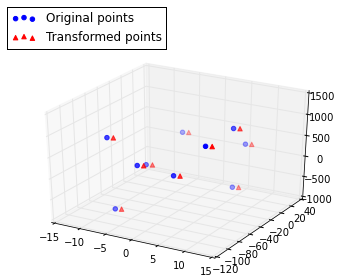

In [8]:
dimension = 3        
t =(1,2,3) 
translation = sitk.TranslationTransform(dimension, t)

# Only need to copy the translational component.
rigid_euler = sitk.Euler3DTransform()
rigid_euler.SetTranslation(translation.GetOffset())

rigid_versor = sitk.VersorRigid3DTransform()
rigid_versor.SetTranslation(translation.GetOffset())

# Sanity check to make sure the transformations are equivalent.
bounds = [(-10,10),(-100,100), (-1000,1000)]
num_points = 10
point_list = uniform_random_points(bounds, num_points)
transformed_point_list = [ translation.TransformPoint(p) for p in point_list]

# Draw the original and transformed points, include the label so that we 
# can modify the plots without requiring explicit changes to the legend.
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
orig = ax.scatter(list(np.array(point_list).T)[0],
                  list(np.array(point_list).T)[1],
                  list(np.array(point_list).T)[2], 
                  marker='o', 
                  color='blue',
                  label='Original points')
transformed = ax.scatter(list(np.array(transformed_point_list).T)[0],
                         list(np.array(transformed_point_list).T)[1],
                         list(np.array(transformed_point_list).T)[2], 
                         marker='^', 
                         color='red', 
                         label='Transformed points')
plt.legend(loc=(0.0,1.0))

euler_errors = target_registration_errors(rigid_euler, point_list, transformed_point_list)
versor_errors = target_registration_errors(rigid_versor, point_list, transformed_point_list)

print('Euler\tminError: {:.2f} maxError: {:.2f}'.format(min(euler_errors), max(euler_errors)))
print('Versor\tminError: {:.2f} maxError: {:.2f}'.format(min(versor_errors), max(versor_errors)))

## Rotation to Rigid [3D]
Copy the matrix or versor and <b>center of rotation</b>.

Euler	minError: 0.00 maxError: 0.00
Versor	minError: 28.28 maxError: 28.28


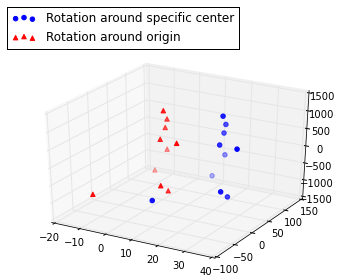

In [9]:
rotationCenter = (10, 10, 10)
rotation = sitk.VersorTransform([0,0,1,0], rotationCenter)

rigid_euler = sitk.Euler3DTransform()
rigid_euler.SetMatrix(rotation.GetMatrix())
rigid_euler.SetCenter(rotation.GetCenter())

rigid_versor = sitk.VersorRigid3DTransform()
rigid_versor.SetRotation(rotation.GetVersor())
#rigid_versor.SetCenter(rotation.GetCenter()) #intentional error

# Sanity check to make sure the transformations are equivalent.
bounds = [(-10,10),(-100,100), (-1000,1000)]
num_points = 10
point_list = uniform_random_points(bounds, num_points)
transformed_point_list = [ rotation.TransformPoint(p) for p in point_list]

euler_errors = target_registration_errors(rigid_euler, point_list, transformed_point_list)
versor_errors = target_registration_errors(rigid_versor, point_list, transformed_point_list)

# Draw the points transformed by the original transformation and after transformation
# using the incorrect transformation, illustrate the effect of center of rotation.
from mpl_toolkits.mplot3d import Axes3D
incorrect_transformed_point_list = [ rigid_versor.TransformPoint(p) for p in point_list]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
orig = ax.scatter(list(np.array(transformed_point_list).T)[0],
                  list(np.array(transformed_point_list).T)[1],
                  list(np.array(transformed_point_list).T)[2], 
                  marker='o', 
                  color='blue',
                  label='Rotation around specific center')
transformed = ax.scatter(list(np.array(incorrect_transformed_point_list).T)[0],
                         list(np.array(incorrect_transformed_point_list).T)[1],
                         list(np.array(incorrect_transformed_point_list).T)[2], 
                         marker='^', 
                         color='red', 
                         label='Rotation around origin')
plt.legend(loc=(0.0,1.0))

print('Euler\tminError: {:.2f} maxError: {:.2f}'.format(min(euler_errors), max(euler_errors)))
print('Versor\tminError: {:.2f} maxError: {:.2f}'.format(min(versor_errors), max(versor_errors)))

## Similarity [2D]

When the center of the similarity transformation is not at the origin the effect of the transformation is not what most of us expect. This is readily visible if we limit the transformation to scaling: $T(\mathbf{x}) = s\mathbf{x}-s\mathbf{c} + \mathbf{c}$. Changing the transformation's center results in scale + translation.

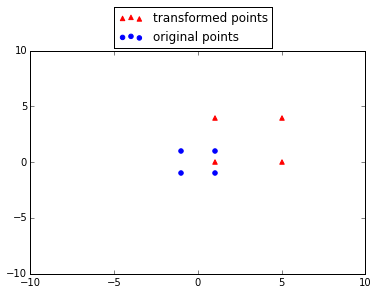

In [23]:
def display_center_effect(x, y, tx, point_list, xlim, ylim):
    tx.SetCenter((x,y))
    transformed_point_list = [ tx.TransformPoint(p) for p in point_list]

    plt.scatter(list(np.array(transformed_point_list).T)[0],
                list(np.array(transformed_point_list).T)[1],
                marker='^', 
                color='red', label='transformed points')
    plt.scatter(list(np.array(point_list).T)[0],
                list(np.array(point_list).T)[1],
                marker='o', 
                color='blue', label='original points')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(loc=(0.25,1.01))

# 2D square centered on (0,0)
points = [np.array((-1,-1)), np.array((-1,1)), np.array((1,1)), np.array((1,-1))]

# Scale by 2 
similarity = sitk.Similarity2DTransform();
similarity.SetScale(2)

interact(display_center_effect, x=(-10,10), y=(-10,10),tx = fixed(similarity), point_list = fixed(points), 
         xlim = fixed((-10,10)),ylim = fixed((-10,10)));

## Rigid to Similarity [3D]
Copy the translation, center, and matrix or versor.

In [11]:
rotation_center = (100, 100, 100)
theta_x = 0.0
theta_y = 0.0
theta_z = np.pi/2.0
translation = (1,2,3)

rigid_euler = sitk.Euler3DTransform(rotation_center, theta_x, theta_y, theta_z, translation)

similarity = sitk.Similarity3DTransform()
similarity.SetMatrix(rigid_euler.GetMatrix())
similarity.SetTranslation(rigid_euler.GetTranslation())
similarity.SetCenter(rigid_euler.GetCenter())

# Apply the transformations to the same set of random points and compare the results
# (see utility functions at top of notebook).
print_transformation_differences(rigid_euler, similarity)

Euler3DTransform-Similarity3DTransform:	minDifference: 0.00 maxDifference: 0.00


## Similarity to Affine [3D]
Copy the translation, center and matrix.

In [12]:
rotation_center = (100, 100, 100)
axis = (0,0,1)
angle = np.pi/2.0
translation = (1,2,3)
scale_factor = 2.0
similarity = sitk.Similarity3DTransform(scale_factor, axis, angle, translation, rotation_center)

affine = sitk.AffineTransform(3)
affine.SetMatrix(similarity.GetMatrix())
affine.SetTranslation(similarity.GetTranslation())
affine.SetCenter(similarity.GetCenter())

# Apply the transformations to the same set of random points and compare the results
# (see utility functions at top of notebook).
print_transformation_differences(similarity, affine)

Similarity3DTransform-AffineTransform:	minDifference: 0.00 maxDifference: 0.00


## Scale Transform

Just as the case was for the similarity transformation above, when the transformations center is not at the origin, instead of a pure anisotropic scaling we also have translation ($T(\mathbf{x}) = \mathbf{s}^T\mathbf{x}-\mathbf{s}^T\mathbf{c} + \mathbf{c}$).

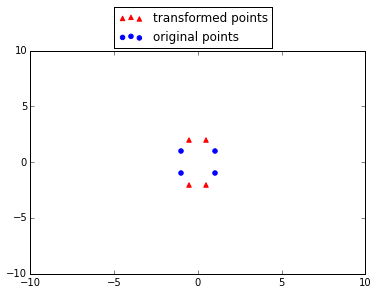

In [13]:
# 2D square centered on (0,0).
points = [np.array((-1,-1)), np.array((-1,1)), np.array((1,1)), np.array((1,-1))]

# Scale by half in x and 2 in y.
scale = sitk.ScaleTransform(2, (0.5,2));

# Interactively change the location of the center.
interact(display_center_effect, x=(-10,10), y=(-10,10),tx = fixed(scale), point_list = fixed(points), 
         xlim = fixed((-10,10)),ylim = fixed((-10,10)));

## Scale Versor

This is not what you would expect from the name (composition of anisotropic scaling and rigid). This is:
$$T(x) = (R+S)(\mathbf{x}-\mathbf{c}) + \mathbf{t} + \mathbf{c},\;\; \textrm{where } S= \left[\begin{array}{ccc} s_0-1 & 0 & 0 \\ 0 & s_1-1 & 0 \\ 0 & 0 & s_2-1 \end{array}\right]$$ 

There is no natural way of "promoting" the similarity transformation to this transformation.

In [14]:
scales = (0.5,0.7,0.9)
translation = (1,2,3)
axis = (0,0,1)
angle = 0.0
scale_versor = sitk.ScaleVersor3DTransform(scales, axis, angle, translation)
print(scale_versor)

itk::simple::ScaleVersor3DTransform
 ScaleVersor3DTransform (0x3f36710)
   RTTI typeinfo:   itk::ScaleVersor3DTransform<double>
   Reference Count: 1
   Modified Time: 945
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.5 0 0 
     0 0.7 0 
     0 0 0.9 
   Offset: [1, 2, 3]
   Center: [0, 0, 0]
   Translation: [1, 2, 3]
   Inverse: 
     2 0 0 
     0 1.42857 0 
     0 0 1.11111 
   Singular: 0
   Versor: [ 0, 0, 0, 1 ]
   Scales:       [0.5, 0.7, 0.9]



## Scale Skew Versor

Again, not what you expect based on the name, this is not a composition of transformations. This is:
$$T(x) = (R+S+K)(\mathbf{x}-\mathbf{c}) + \mathbf{t} + \mathbf{c},\;\; \textrm{where } S = \left[\begin{array}{ccc} s_0-1 & 0 & 0 \\ 0 & s_1-1 & 0 \\ 0 & 0 & s_2-1 \end{array}\right]\;\; \textrm{and } K = \left[\begin{array}{ccc} 0 & k_0 & k_1 \\ k_2 & 0 & k_3 \\ k_4 & k_5 & 0 \end{array}\right]$$ 

In practice this is an over-parametrized version of the affine transform, 15 (scale, skew, versor, translation) vs. 12 parameters (matrix, translation).

In [15]:
scale = (2,2.1,3)
skew = np.linspace(start=0.0, stop=1.0, num=6) #six eqaully spaced values in[0,1], an arbitrary choice
translation = (1,2,3)
versor = (0,0,0,1.0)
scale_skew_versor = sitk.ScaleSkewVersor3DTransform(scale, skew, versor, translation)
print(scale_skew_versor)

itk::simple::ScaleSkewVersor3DTransform
 ScaleSkewVersor3DTransform (0x40ed030)
   RTTI typeinfo:   itk::ScaleSkewVersor3DTransform<double>
   Reference Count: 1
   Modified Time: 952
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     2 0 0.2 
     0.4 2.1 0.6 
     0.8 1 3 
   Offset: [1, 2, 3]
   Center: [0, 0, 0]
   Translation: [1, 2, 3]
   Inverse: 
     0.511486 0.0179469 -0.0376884 
     -0.0646088 0.524049 -0.100503 
     -0.11486 -0.179469 0.376884 
   Singular: 0
   Versor: [ 0, 0, 0, 1 ]
   Scale:       [2, 2.1, 3]
   Skew:        [0, 0.2, 0.4, 0.6, 0.8, 1]



## Bounded Transformations

SimpleITK supports two types of bounded non-rigid transformations, BSplineTransform (sparse represntation) and 	DisplacementFieldTransform (dense representation).

Transforming a point that is outside the bounds will return the original point - identity transform.

In [16]:
#
# This function displays the effects of the deformable transformation on a grid of points by scaling the
# initial displacements (either of control points for bspline or the deformation field itself). It does
# assume that all points are contained in the range(-2.5,-2.5), (2.5,2.5).
#
def display_displacement_scaling_effect(s, original_x_mat, original_y_mat, tx, original_control_point_displacements):
    if tx.GetDimension() !=2:
        raise ValueError('display_displacement_scaling_effect only works in 2D')

    plt.scatter(original_x_mat,
                original_y_mat,
                marker='o', 
                color='blue', label='original points')
    pointsX = []
    pointsY = []
    tx.SetParameters(s*original_control_point_displacements)
  
    for index, value in np.ndenumerate(original_x_mat):
        px,py = tx.TransformPoint((value, original_y_mat[index]))
        pointsX.append(px) 
        pointsY.append(py)
     
    plt.scatter(pointsX,
                pointsY,
                marker='^', 
                color='red', label='transformed points')
    plt.legend(loc=(0.25,1.01))
    plt.xlim((-2.5,2.5))
    plt.ylim((-2.5,2.5))

## BSpline
Using a sparse set of control points to control a free form deformation.

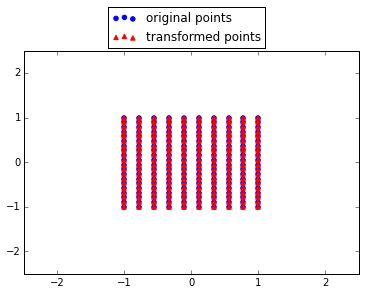

In [17]:
# Create the transformation (when working with images it is easier to use the BSplineTransformInitializer function
# or its object oriented counterpart BSplineTransformInitializerFilter).
dimension = 2
spline_order = 3
direction_matrix_row_major = [1.0,0.0,0.0,1.0] # identity, mesh is axis aligned
origin = [-1.0,-1.0]  
domain_physical_dimensions = [2,2]

bspline = sitk.BSplineTransform(dimension, spline_order)
bspline.SetTransformDomainOrigin(origin)
bspline.SetTransformDomainDirection(direction_matrix_row_major)
bspline.SetTransformDomainPhysicalDimensions(domain_physical_dimensions)
bspline.SetTransformDomainMeshSize((4,3))

# Random displacement of the control points.
originalControlPointDisplacements = np.random.random(len(bspline.GetParameters()))
bspline.SetParameters(originalControlPointDisplacements)

# Apply the bspline transformation to a grid of points 
# starting the point set exactly at the origin of the bspline mesh is problematic as
# these points are considered outside the transformation's domain,
# remove epsilon below and see what happens.
numSamplesX = 10
numSamplesY = 20
                   
coordsX = np.linspace(origin[0]+np.finfo(float).eps, origin[0] + domain_physical_dimensions[0], numSamplesX)
coordsY = np.linspace(origin[1]+np.finfo(float).eps, origin[1] + domain_physical_dimensions[1], numSamplesY)
XX, YY = np.meshgrid(coordsX, coordsY)

interact(display_displacement_scaling_effect, s= (-1.5,1.5), original_x_mat = fixed(XX), original_y_mat = fixed(YY),
         tx = fixed(bspline), original_control_point_displacements = fixed(originalControlPointDisplacements));            

## DisplacementField

A dense set of vectors representing the displacment inside the given domain. The most generic representation of a transformation.

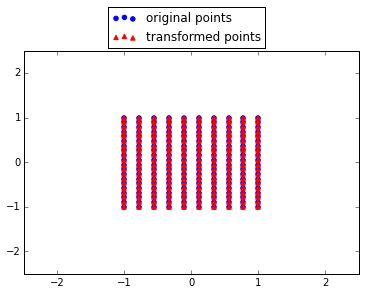

In [18]:
# Create the displacment field. 
    
# When working with images the safer thing to do is use the image based constructor,
# sitk.DisplacementFieldTransform(my_image), all the fixed parameters will be set correctly and the displacement
# field is initialized using the vectors stored in the image. SimpleITK requires that the image's pixel type be 
# sitk.sitkVectorFloat64.
displacement = sitk.DisplacementFieldTransform(2)
field_size = [10,20]
field_origin = [-1.0,-1.0]  
field_spacing = [2.0/9.0,2.0/19.0]   
field_direction = [1,0,0,1] # direction cosine matrix (row major order)     

# Concatenate all the information into a single list
displacement.SetFixedParameters(field_size+field_origin+field_spacing+field_direction)
# Set the interpolater, either sitkLinear which is default or nearest neighbor
displacement.SetInterpolator(sitk.sitkNearestNeighbor)

originalDisplacements = np.random.random(len(displacement.GetParameters()))
displacement.SetParameters(originalDisplacements)

coordsX = np.linspace(field_origin[0], field_origin[0]+(field_size[0]-1)*field_spacing[0], field_size[0])
coordsY = np.linspace(field_origin[1], field_origin[1]+(field_size[1]-1)*field_spacing[1], field_size[1])
XX, YY = np.meshgrid(coordsX, coordsY)

interact(display_displacement_scaling_effect, s= (-1.5,1.5), original_x_mat = fixed(XX), original_y_mat = fixed(YY),
         tx = fixed(displacement), original_control_point_displacements = fixed(originalDisplacements));            

Displacement field transform created from an image. Remember that SimpleITK will clear the image you provide, as shown in the cell below.

In [19]:
displacement_image = sitk.Image([64,64], sitk.sitkVectorFloat64)
# The only point that has any displacement is (0,0)
displacement = (0.5,0.5)
displacement_image[0,0] = displacement

print('Original displacement image size: ' + point2str(displacement_image.GetSize()))

displacement_field_transform = sitk.DisplacementFieldTransform(displacement_image)

print('After using the image to create a transform, displacement image size: ' + point2str(displacement_image.GetSize()))

# Check that the displacement field transform does what we expect.
print('Expected result: {0}\nActual result:{1}'.format(str(displacement), displacement_field_transform.TransformPoint((0,0))))

Original displacement image size: 64.0 64.0
After using the image to create a transform, displacement image size: 0.0 0.0
Expected result: (0.5, 0.5)
Actual result:(0.5, 0.5)


## Composite transform (Transform)

The generic SimpleITK transform class. This class can represent both a single transformation (global, local), or a composite transformation (multiple transformations applied one after the other). This is the output typed returned by the SimpleITK registration framework. 

The choice of whether to use a composite transformation or compose transformations on your own has subtle differences in the registration framework.

Below we represent the composite transformation $T_{affine}(T_{rigid}(x))$ in two ways: (1) use a composite transformation to contain the two; (2) combine the two into a single affine transformation. We can use both as initial transforms (SetInitialTransform) for the registration framework (ImageRegistrationMethod). The difference is that in the former case the optimized parameters belong to the rigid transformation and in the later they belong to the combined-affine transformation. 

In [20]:
# Create a composite transformation: T_affine(T_rigid(x)).
rigid_center = (100,100,100)
theta_x = 0.0
theta_y = 0.0
theta_z = np.pi/2.0
rigid_translation = (1,2,3)
rigid_euler = sitk.Euler3DTransform(rigid_center, theta_x, theta_y, theta_z, rigid_translation)

affine_center = (20, 20, 20)
affine_translation = (5,6,7)  

# Matrix is represented as a vector-like data in row major order.
affine_matrix = np.random.random(9)         
affine = sitk.AffineTransform(affine_matrix, affine_translation, affine_center)

# Using the composite transformation we just add them in (stack based, first in - last applied).
composite_transform = sitk.Transform(affine)
composite_transform.AddTransform(rigid_euler)

# Create a single transform manually. this is a recipe for compositing any two global transformations
# into an affine transformation, T_0(T_1(x)):
# A = A=A0*A1
# c = c1
# t = A0*[t1+c1-c0] + t0+c0-c1
A0 = np.asarray(affine.GetMatrix()).reshape(3,3)
c0 = np.asarray(affine.GetCenter())
t0 = np.asarray(affine.GetTranslation())

A1 = np.asarray(rigid_euler.GetMatrix()).reshape(3,3)
c1 = np.asarray(rigid_euler.GetCenter())
t1 = np.asarray(rigid_euler.GetTranslation())

combined_mat = np.dot(A0,A1)
combined_center = c1
combined_translation = np.dot(A0, t1+c1-c0) + t0+c0-c1
combined_affine = sitk.AffineTransform(combined_mat.flatten(), combined_translation, combined_center)

# Check if the two transformations are equivalent.
print('Apply the two transformations to the same point cloud:')
print('\t', end='')
print_transformation_differences(composite_transform, combined_affine)

print('Transform parameters:')
print('\tComposite transform: ' + point2str(composite_transform.GetParameters(),2))
print('\tCombined affine: ' + point2str(combined_affine.GetParameters(),2))

print('Fixed parameters:')
print('\tComposite transform: ' + point2str(composite_transform.GetFixedParameters(),2))
print('\tCombined affine: ' + point2str(combined_affine.GetFixedParameters(),2))

Apply the two transformations to the same point cloud:
	Transform-AffineTransform:	minDifference: 0.00 maxDifference: 0.00
Transform parameters:
	Composite transform: 0.00 0.00 1.57 1.00 2.00 3.00
	Combined affine: 0.68 -0.93 0.46 0.96 -0.39 0.55 0.70 -0.18 0.38 94.93 82.30 29.94
Fixed parameters:
	Composite transform: 100.00 100.00 100.00
	Combined affine: 100.00 100.00 100.00


Composite transforms enable a combination of a global transformation with multiple local/bounded transformations. This is useful if we want to apply deformations only in regions that deform while other regions are only effected by the global transformation.

The following code illustrates this, where the whole region is translated and subregions have different deformations.

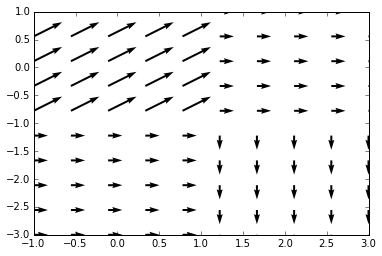

In [21]:
# Global transformation.
translation = sitk.TranslationTransform(2,(1.0,0.0))

# Displacement in region 1.
displacement1 = sitk.DisplacementFieldTransform(2)
field_size = [10,20]
field_origin = [-1.0,-1.0]  
field_spacing = [2.0/9.0,2.0/19.0]   
field_direction = [1,0,0,1] # direction cosine matrix (row major order)     

# Concatenate all the information into  a single list.
displacement1.SetFixedParameters(field_size+field_origin+field_spacing+field_direction)
displacement1.SetParameters(np.ones(len(displacement1.GetParameters())))

# Displacement in region 2.
displacement2 = sitk.DisplacementFieldTransform(2)
field_size = [10,20]
field_origin = [1.0,-3]  
field_spacing = [2.0/9.0,2.0/19.0]   
field_direction = [1,0,0,1] #direction cosine matrix (row major order)     

# Concatenate all the information into a single list.
displacement2.SetFixedParameters(field_size+field_origin+field_spacing+field_direction)
displacement2.SetParameters(-1.0*np.ones(len(displacement2.GetParameters())))

# Composite transform which applies the global and local transformations.
composite = sitk.Transform(translation)
composite.AddTransform(displacement1)
composite.AddTransform(displacement2)

# Apply the composite transformation to points in ([-1,-3],[3,1]) and 
# display the deformation using a quiver plot.
        
# Generate points.
numSamplesX = 10
numSamplesY = 10                   
coordsX = np.linspace(-1.0, 3.0, numSamplesX)
coordsY = np.linspace(-3.0, 1.0, numSamplesY)
XX, YY = np.meshgrid(coordsX, coordsY)

# Transform points and compute deformation vectors.
pointsX = np.zeros(XX.shape)
pointsY = np.zeros(XX.shape)
for index, value in np.ndenumerate(XX):
    px,py = composite.TransformPoint((value, YY[index]))
    pointsX[index]=px - value 
    pointsY[index]=py - YY[index]
    
plt.quiver(XX, YY, pointsX, pointsY);    

## Writing and Reading

The SimpleITK.ReadTransform() returns a SimpleITK.Transform . The content of the file can be any of the SimpleITK transformations or a composite (set of tranformations). 

In [22]:
import os

# Create a 2D rigid transformation, write it to disk and read it back.
basic_transform = sitk.Euler2DTransform()
basic_transform.SetTranslation((1,2))
basic_transform.SetAngle(np.pi/2)

full_file_name = os.path.join(OUTPUT_DIR, 'euler2D.tfm')

sitk.WriteTransform(basic_transform, full_file_name)

# The ReadTransform function returns an sitk.Transform no matter the type of the transform 
# found in the file (global, bounded, composite).
read_result = sitk.ReadTransform(full_file_name)

print('Different types: '+ str(type(read_result) != type(basic_transform)))
print_transformation_differences(basic_transform, read_result)


# Create a composite transform then write and read.
displacement = sitk.DisplacementFieldTransform(2)
field_size = [10,20]
field_origin = [-10.0,-100.0]  
field_spacing = [20.0/(field_size[0]-1),200.0/(field_size[1]-1)]   
field_direction = [1,0,0,1] #direction cosine matrix (row major order)

# Concatenate all the information into a single list.
displacement.SetFixedParameters(field_size+field_origin+field_spacing+field_direction)
displacement.SetParameters(np.random.random(len(displacement.GetParameters())))

composite_transform = sitk.Transform(basic_transform)
composite_transform.AddTransform(displacement)

full_file_name = os.path.join(OUTPUT_DIR, 'composite.tfm')

sitk.WriteTransform(composite_transform, full_file_name)
read_result = sitk.ReadTransform(full_file_name)

print_transformation_differences(composite_transform, read_result)    

Different types: True
Euler2DTransform-Transform:	minDifference: 0.00 maxDifference: 0.00
Transform-Transform:	minDifference: 0.00 maxDifference: 0.00
